In [1]:
from Neural_Nets.ThermoNet.Development.ThermoNet import ThermoRegressionNet, ThermoDataset
from Neural_Nets.ThermoNetActFuncs.Development.ThermoNetActFuncs import Sigmoid, Softplus, ChenSundman, ELUFlipped, Log
from Utils.PlotHandler.Development.PlotHandler import PlotHandler 
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop, Adam
from Data_Handling.SGTEHandler.Development.SGTEHandler import SGTEHandler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def epoch(net: ThermoRegressionNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, (temp, g) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)
        
        # Forward pass
        gibbs_energy = net(temp)
        
        # Get the loss
        loss = loss_func(gibbs_energy, g.float())

        # Backward pass
        net.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses[i] = loss

    #print(gibbs_energy.mean(), g.mean())
    mean_epoch_loss = epoch_losses.mean()
    #print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [3]:
def train(net, dataset):
    # Hyperparameters
    n_epochs = 100
    lr = 0.1
    batch_size = 16
    std_thresh = 0.05

    # Data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = Adam(net.parameters(), lr=lr)
    loss_func = nn.MSELoss()

    losses = []
    
    # Keep track of epoch where learning rate was reduced last
    lr_reduced_last = 0

    for i in range(n_epochs):
        #print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss)
        
        # Adapt learning rate if standard deviation over the last 10 epochs is below a threshold
        if np.array(losses[-10:]).std() < std_thresh and (i - lr_reduced_last) >= 10:
            print('Learning rate halfed! \n')
            lr_reduced_last = i
            lr /= 2

In [4]:
net = ThermoRegressionNet(hidden_layers=2, hidden_dim=128, act_func=nn.LeakyReLU())

element = 'Fe'
phase = ['BCC_A2']
dataset = ThermoDataset(element, phase, step=10)

train(net, dataset)

Fe successfully selected!



C:\Users\danie\anaconda3\envs\5_Programmcodes\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\danie\anaconda3\envs\5_Programmcodes\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Learning rate halfed! 

Learning rate halfed! 

Learning rate halfed! 

Learning rate halfed! 

Learning rate halfed! 

Learning rate halfed! 

Learning rate halfed! 

Learning rate halfed! 

Learning rate halfed! 



tensor([[0.4903],
        [0.4903],
        [0.4904],
        ...,
        [0.5245],
        [0.5245],
        [0.5245]], grad_fn=<AddmmBackward0>)
tensor([0.1502, 0.1551, 0.1601, 0.1651, 0.1700, 0.1750, 0.1799, 0.1849, 0.1898,
        0.1947, 0.1997, 0.2046, 0.2095, 0.2144, 0.2193, 0.2242, 0.2291, 0.2340,
        0.2389, 0.2438, 0.2486, 0.2535, 0.2583, 0.2632, 0.2680, 0.2729, 0.2777,
        0.2825, 0.2873, 0.2922, 0.2970, 0.3018, 0.3065, 0.3113, 0.3161, 0.3209,
        0.3256, 0.3304, 0.3351, 0.3398, 0.3445, 0.3493, 0.3540, 0.3587, 0.3633,
        0.3680, 0.3727, 0.3774, 0.3820, 0.3866, 0.3913, 0.3959, 0.4005, 0.4051,
        0.4097, 0.4143, 0.4188, 0.4234, 0.4279, 0.4325, 0.4370, 0.4415, 0.4460,
        0.4505, 0.4550, 0.4595, 0.4639, 0.4684, 0.4728, 0.4772, 0.4816, 0.4860,
        0.4904, 0.4948, 0.4991, 0.5035, 0.5078, 0.5122, 0.5165, 0.5208, 0.5250,
        0.5293, 0.5336, 0.5378, 0.5420, 0.5463, 0.5505, 0.5546, 0.5588, 0.5630,
        0.5671, 0.5713, 0.5754, 0.5795, 0.5836, 0.58

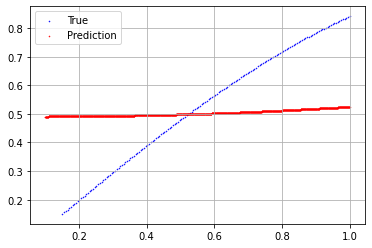

In [5]:
ph = PlotHandler()

ph.properties_temp(net, dataset, input_scaling=True)

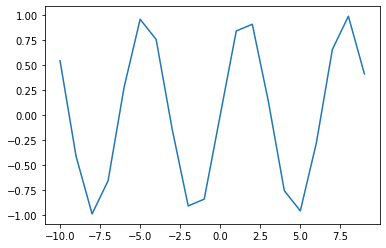

([<matplotlib.lines.Line2D at 0x151894753d0>], None)

In [6]:
x = torch.tensor(list(range(-10, 10, 1)), dtype=torch.float32)
y = torch.sin(x)

plt.plot(x, y), plt.show()